In [94]:
# loading required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import aix360
from aix360.algorithms.rbm import FeatureBinarizer
import shap
shap.initjs()
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [243]:
# load the data
sensor_data= pd.read_csv('C:\\D\\XAI\\Demo\\Dummy_KPI_data.csv')

In [50]:
# see the data disctrubution 
# Plot the distribution of each feature

def plot_distribution(dataset, cols=2, width=30, height=30, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column].dropna())
            plt.xticks(rotation=25)
# we see that most of the values are compareable to each other, not following exactly the normal disctribution ( needs to take
# care when building classification model)     

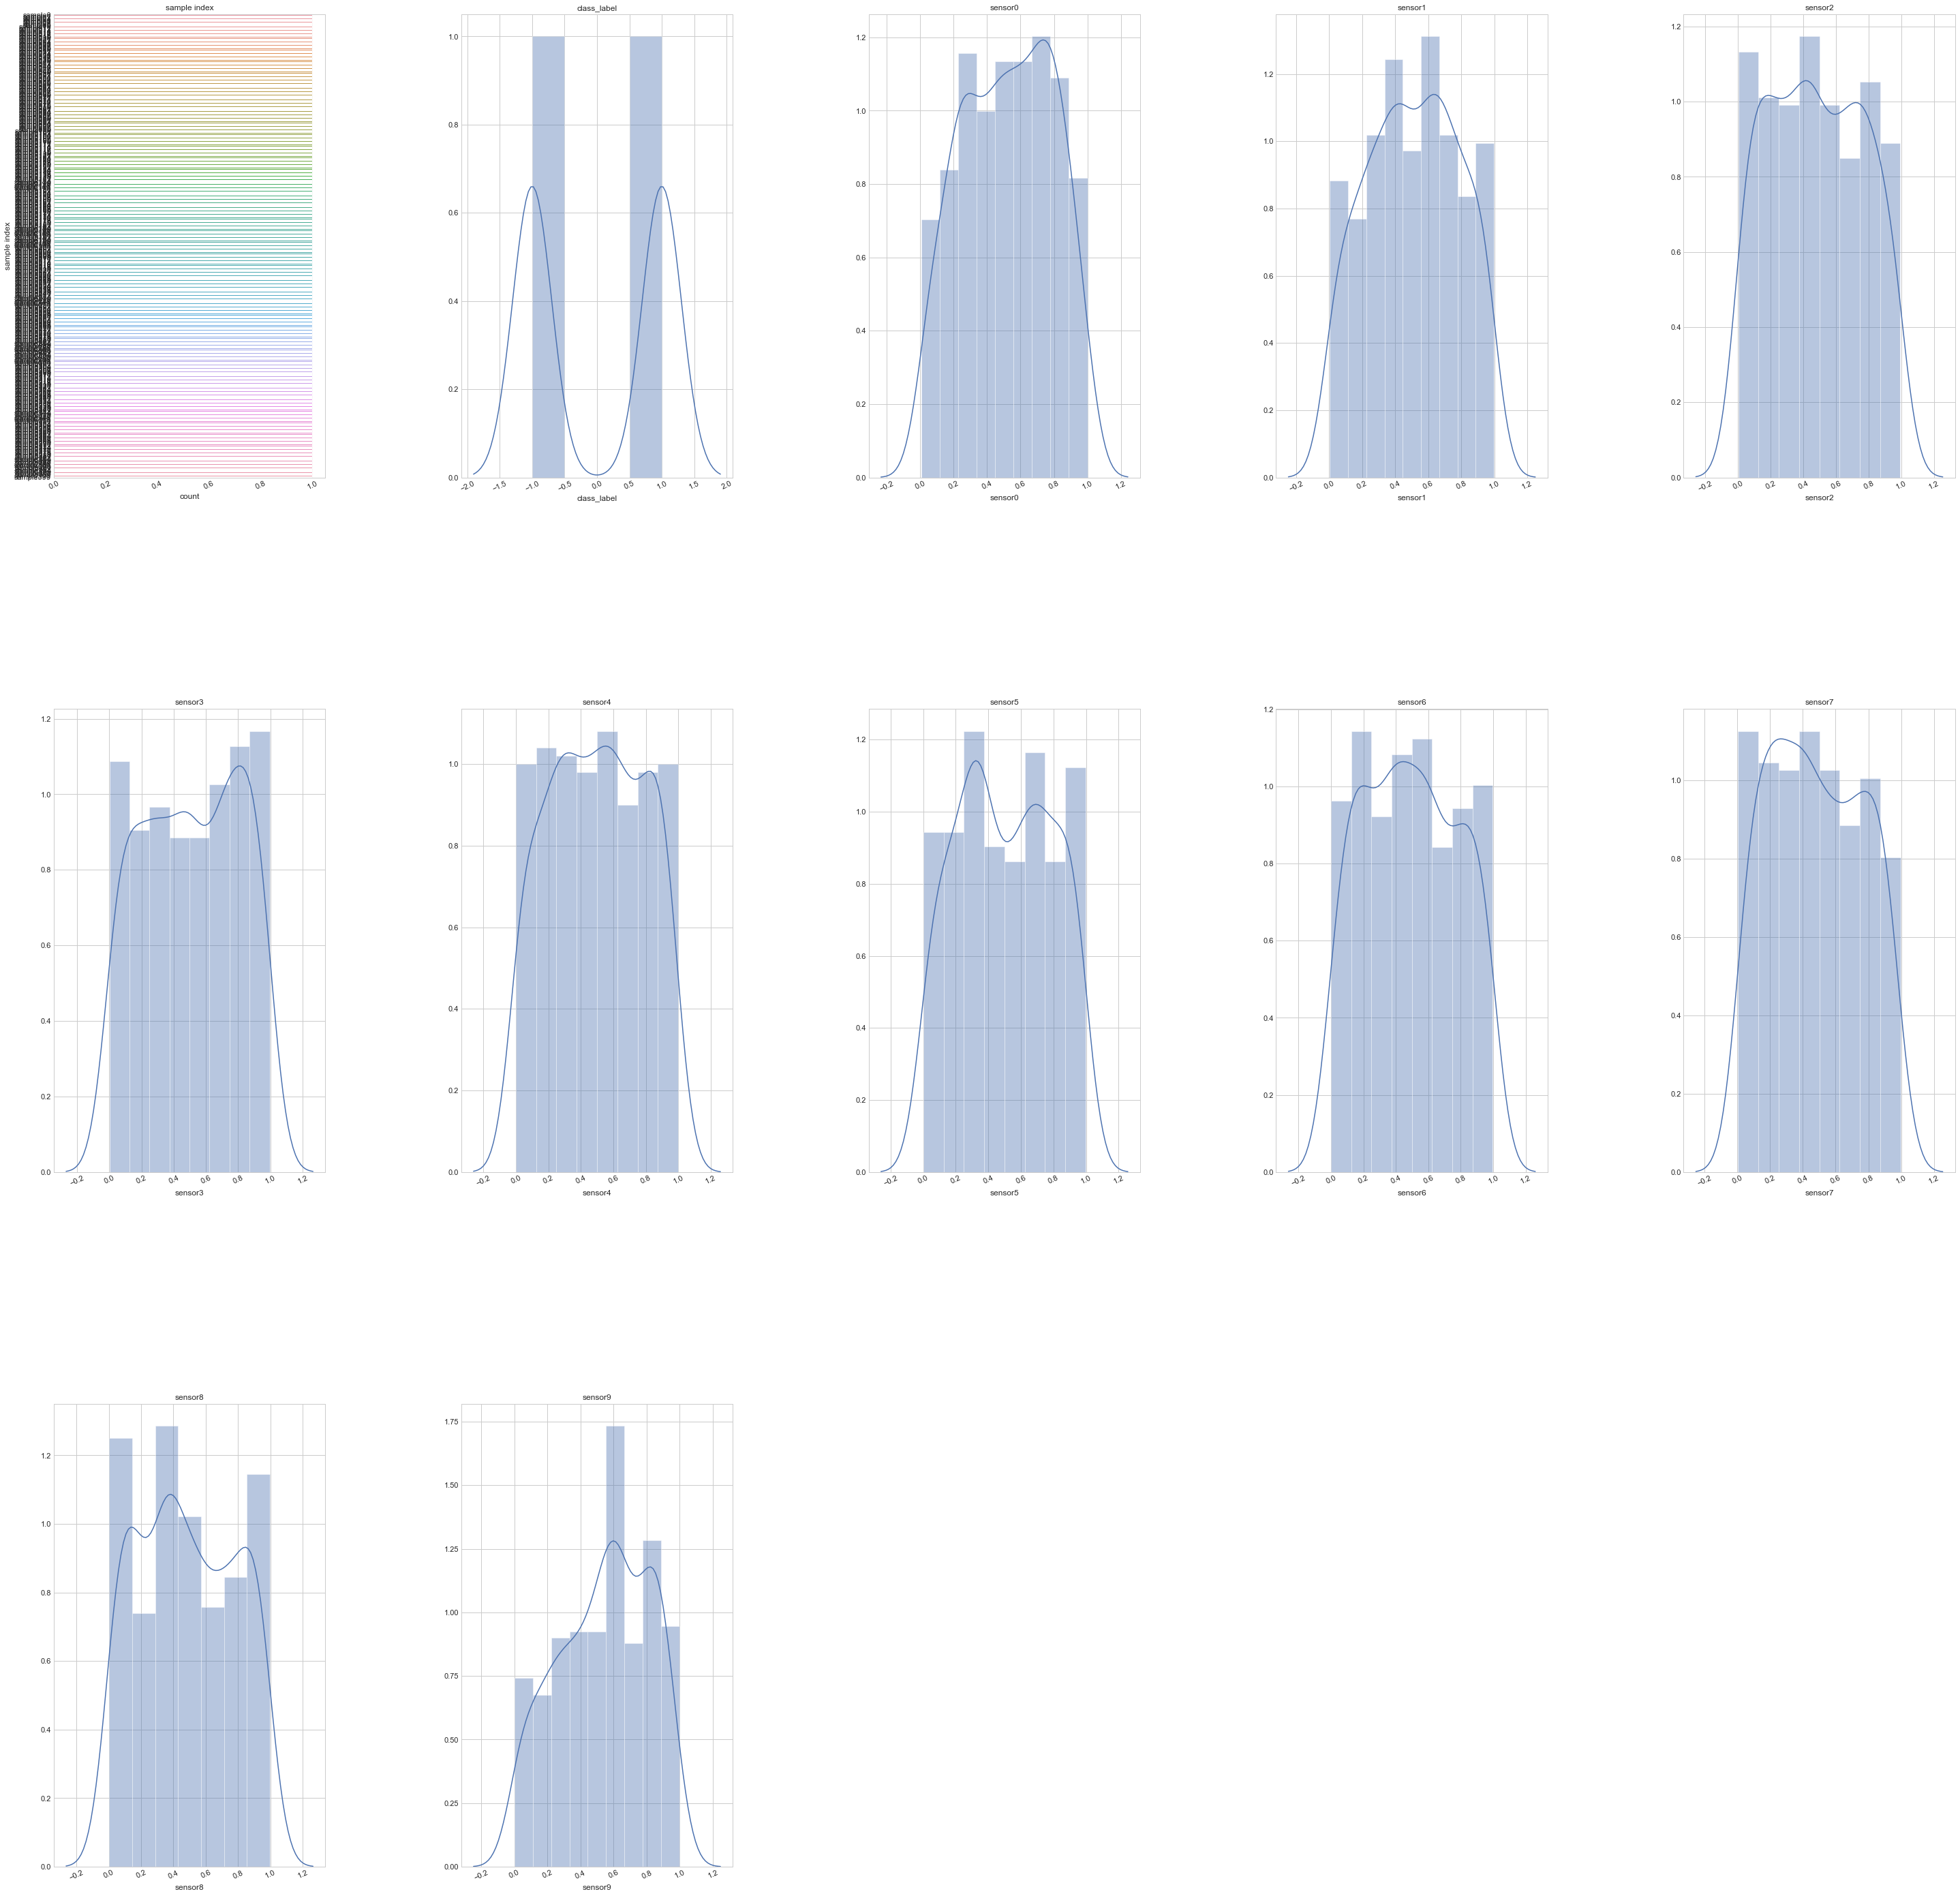

In [51]:
plot_distribution(sensor_data, cols=5, width=50, height=50, hspace=0.5, wspace=0.5)

In [6]:
sensor_data.describe()
# there are no extreme outliers, no missing values, no class imbalance

class_label     sensor0     sensor1     sensor2     sensor3  \
count   400.000000  400.000000  400.000000  400.000000  400.000000   
mean      0.000000    0.523661    0.509223    0.481238    0.509752   
std       1.001252    0.268194    0.276878    0.287584    0.297712   
min      -1.000000    0.007775    0.003865    0.004473    0.001466   
25%      -1.000000    0.299792    0.283004    0.235544    0.262697   
50%       0.000000    0.534906    0.507583    0.460241    0.510066   
75%       1.000000    0.751887    0.727843    0.734937    0.768975   
max       1.000000    0.999476    0.998680    0.992963    0.995119   

          sensor4     sensor5     sensor6     sensor7     sensor8     sensor9  
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000  
mean     0.497875    0.501065    0.490480    0.482372    0.482822    0.541933  
std      0.288208    0.287634    0.289954    0.282714    0.296180    0.272490  
min      0.000250    0.000425    0.000173    0.003322    0.003165    0.000452  
25%      0.249369    0.269430    0.226687    0.242848    0.213626    0.321264  
50%      0.497842    0.497108    0.477341    0.463438    0.462251    0.578389  
75%      0.743401    0.738854    0.735304    0.732483    0.740542    0.768990  
max      0.999412    0.997367    0.997141    0.998230    0.996098    0.999465

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002394506D0F0>,
      dtype=object)

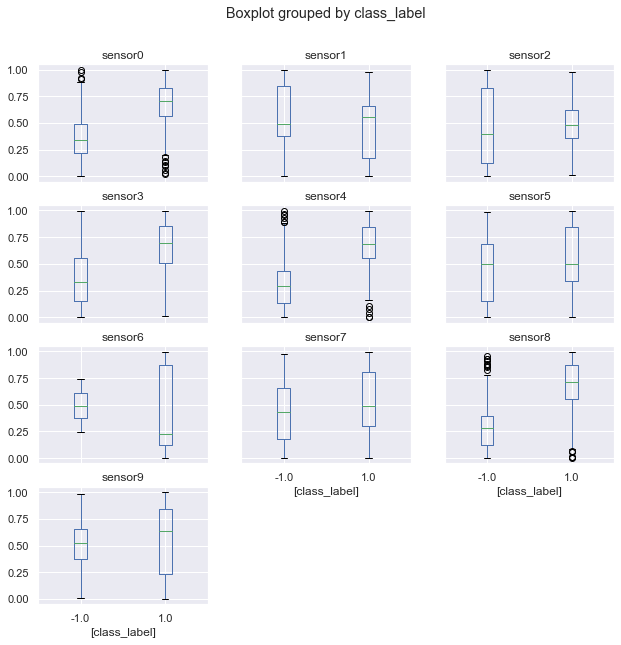

In [47]:
# see the distribution respective of class variable
#sensor_data.boxplot(column=list(sensor_data.columns[2:])) for all the variables in one plot
sensor_data.boxplot(by='class_label', figsize= (10,10))
# here we can see that sensor 0, sensor 4 and sensor 8 are most crucial to determine class variable.Although there are
#outliers in all the variables, present in form of small rings.

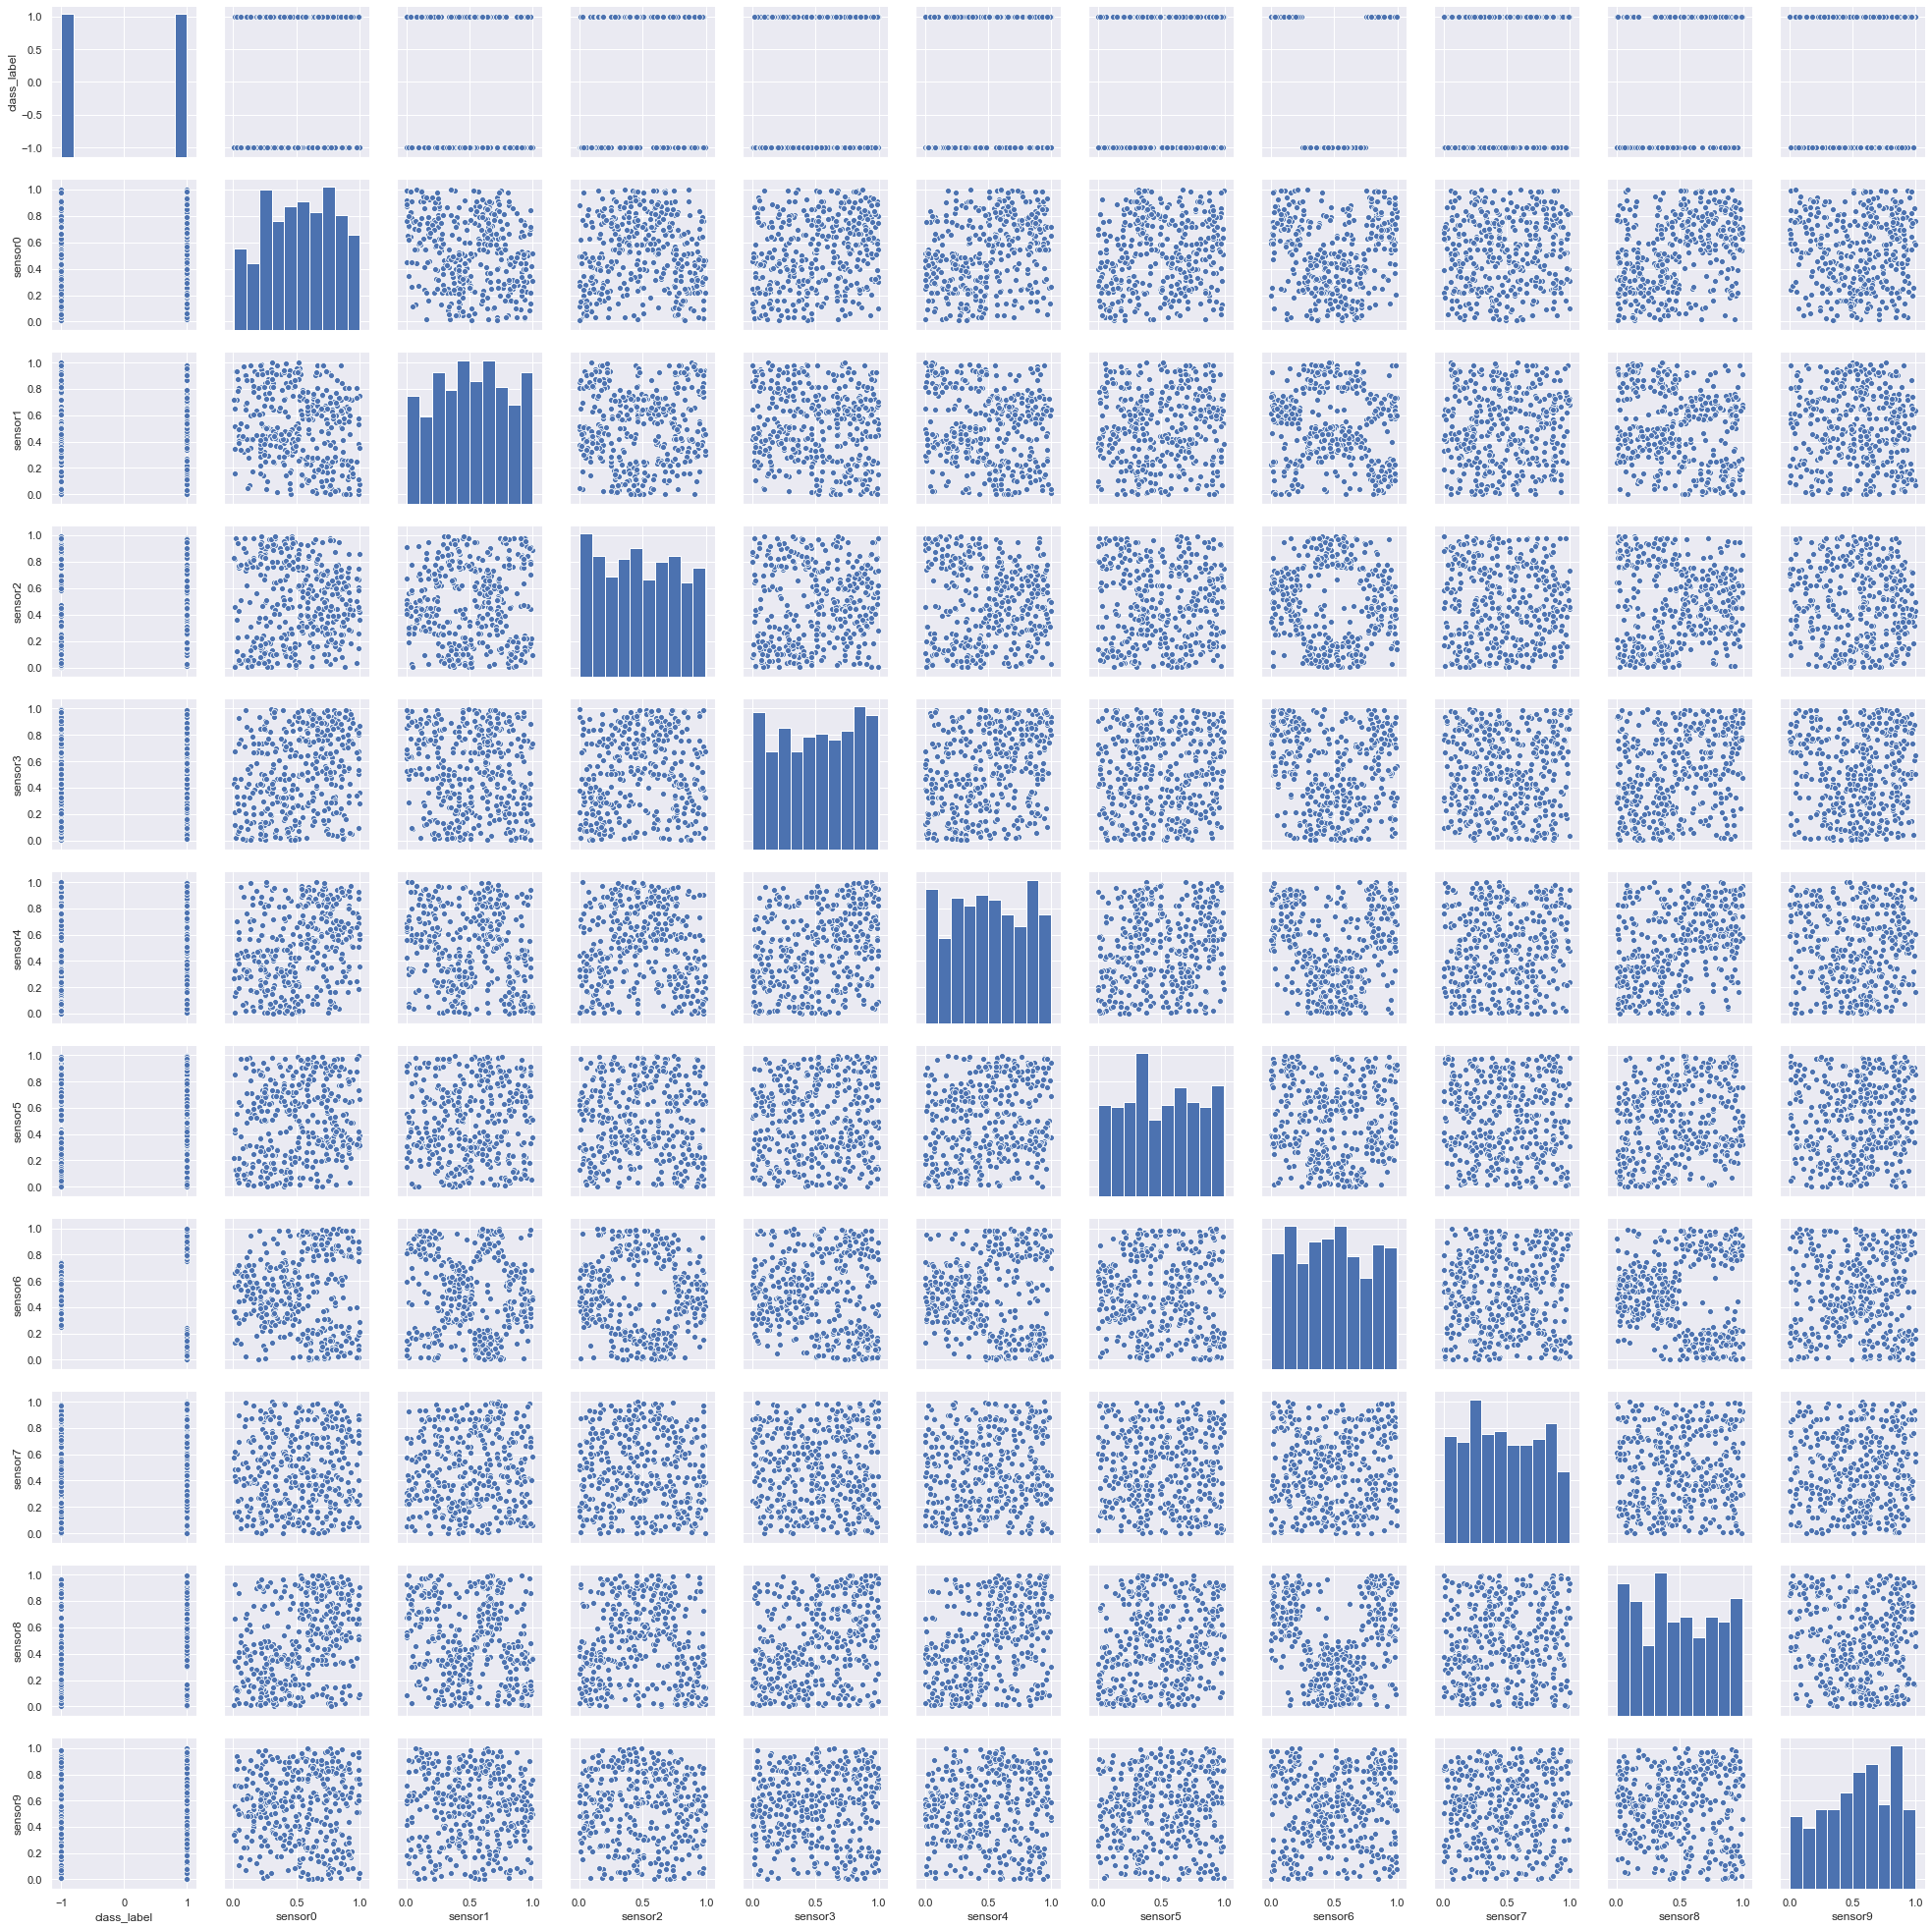

In [9]:
sns.pairplot(sensor_data[sensor_data.columns[1:]])
# sensor 6- sensor 6 shows that near median values are for class -1 and 1st quadrant and 4th quadrant values are lying in class 1
# there is no correlation between and of the sensor variable

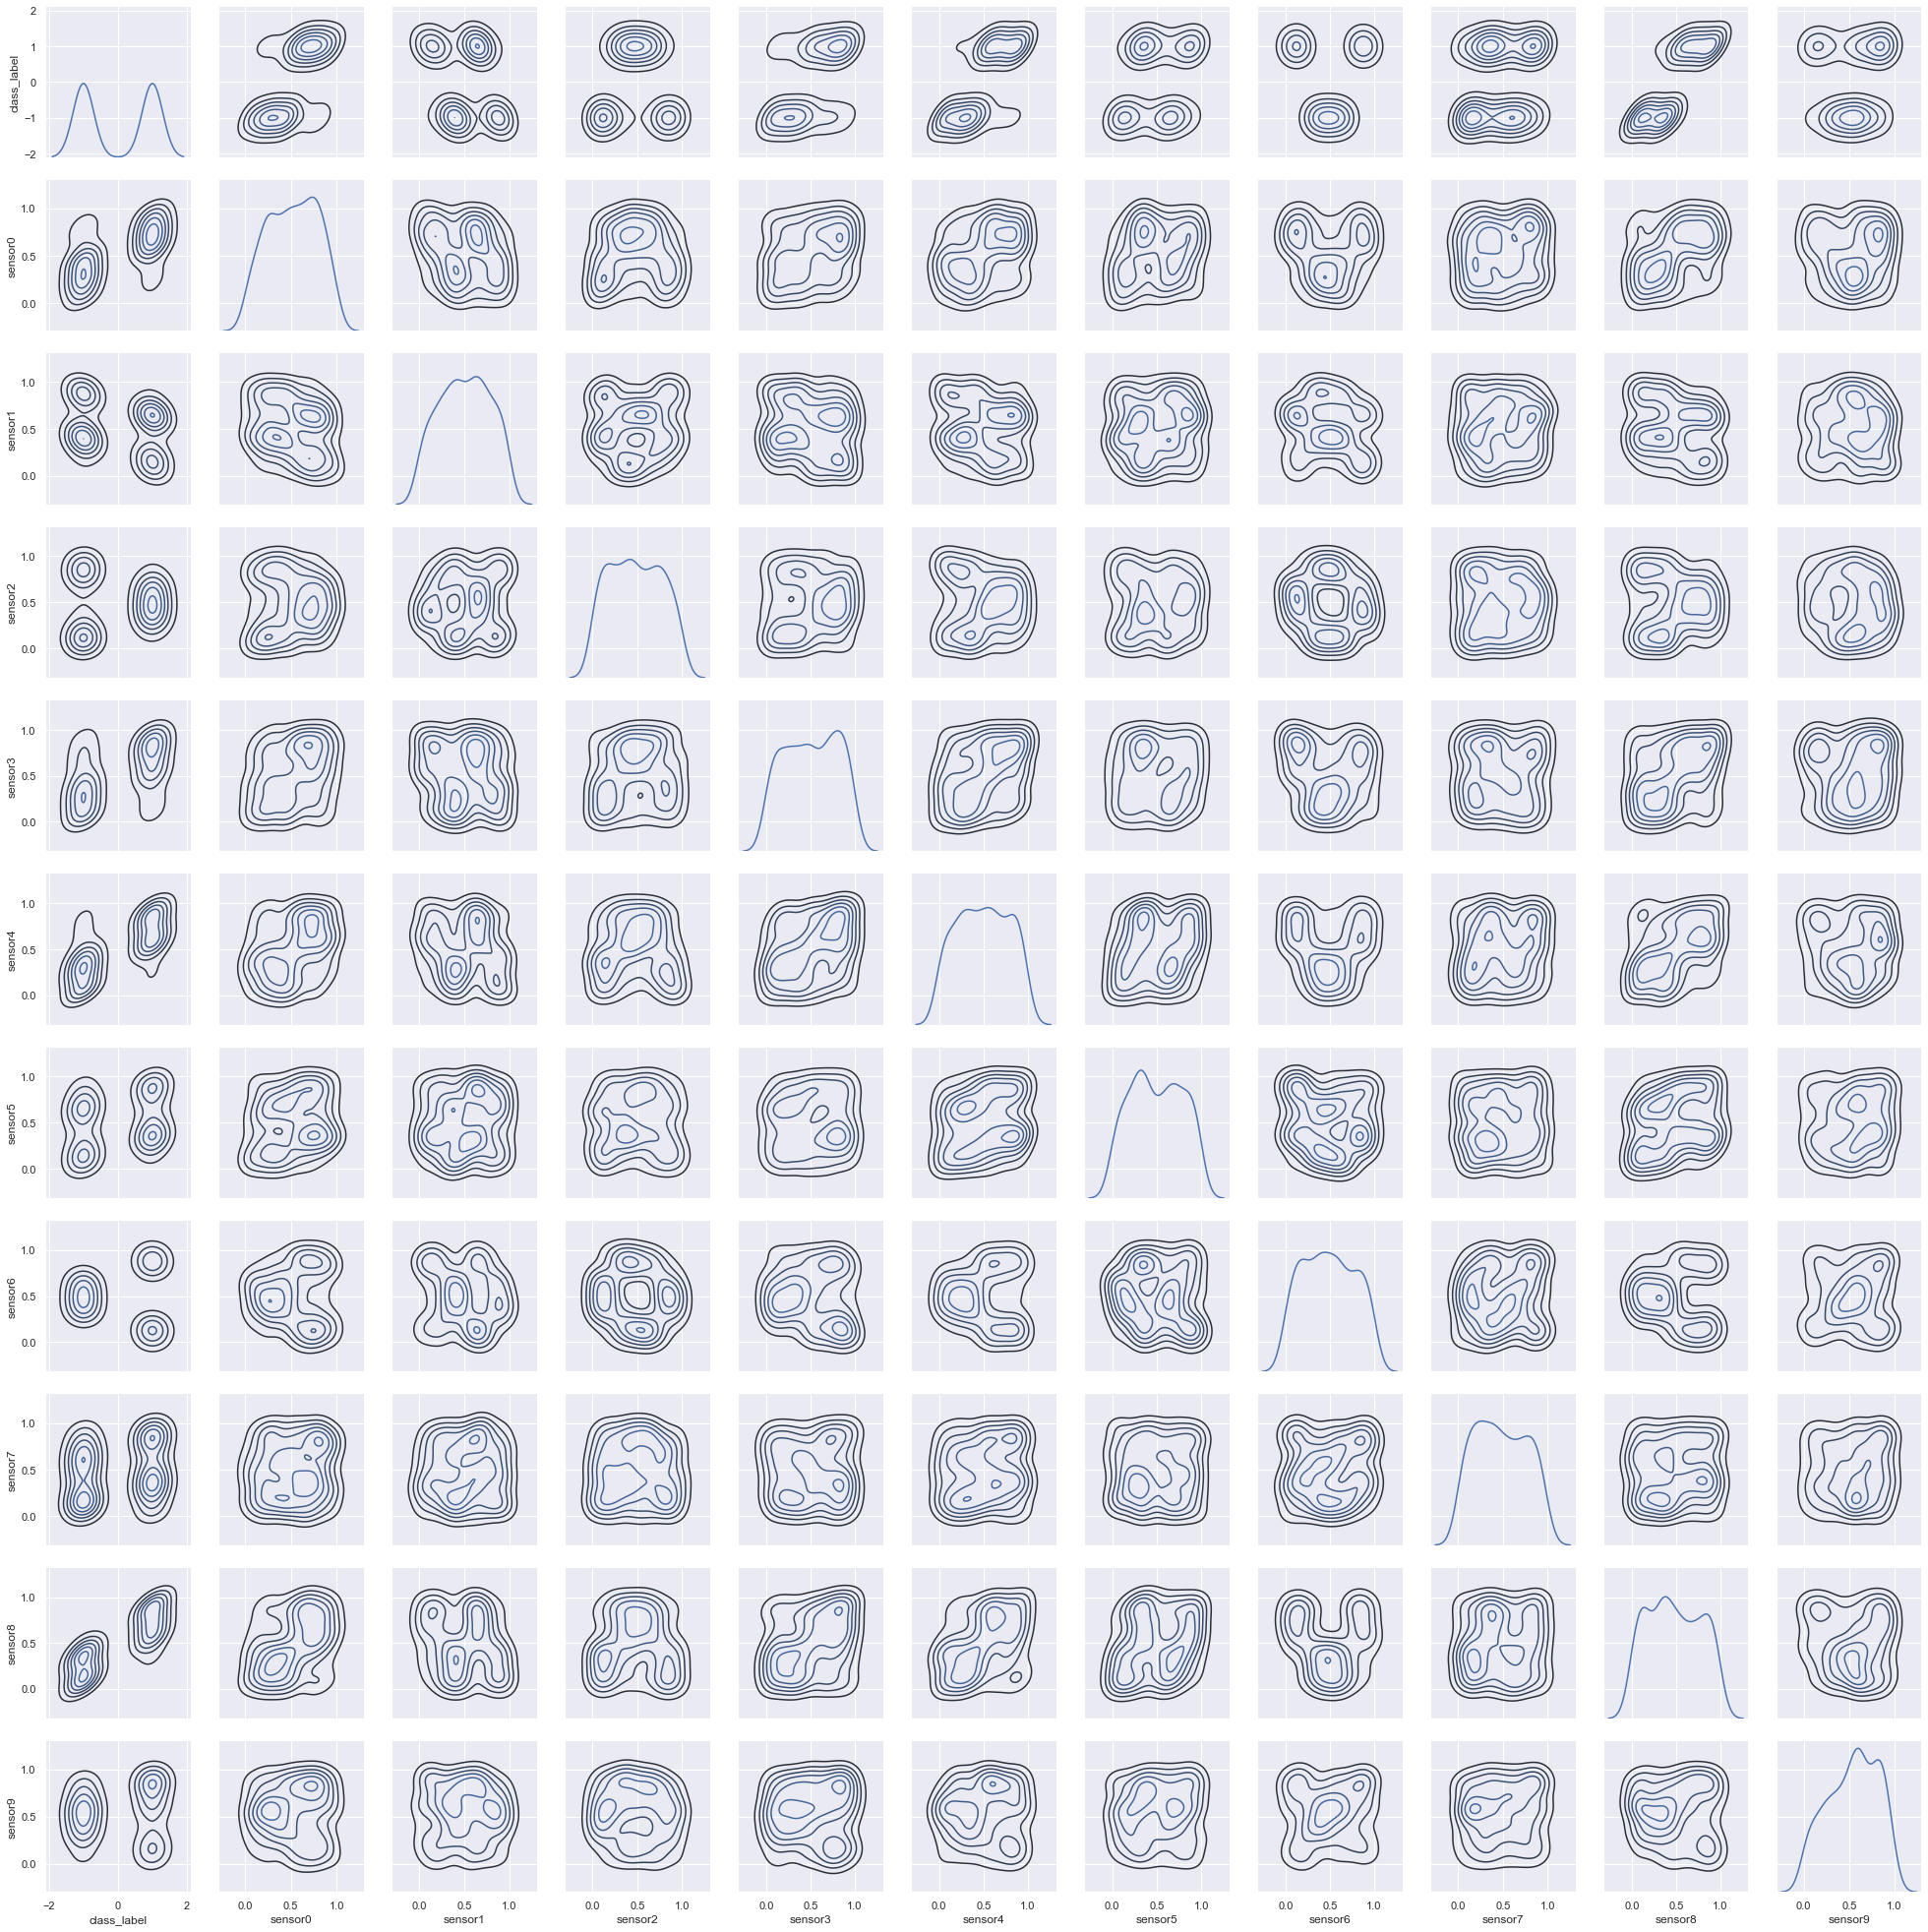

In [10]:
# scatterplots for joint relationships and histograms for univariate distributions
g = sns.PairGrid(sensor_data[sensor_data.columns[1:]])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)

In [95]:
####################################### Feature Importance ##########################################
# here we are trying to find feature imporatnce in simple classifier- Logistic regression and also checking the accuracy of model

X=sensor_data[sensor_data.columns[2:]]
Y= sensor_data.class_label.astype('int64')



model_logistic = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
# feature importance in logistic model and accuracy of model
predicted_y_test= model_logistic.predict(X_test)
print("Accuracy of logistic regression model on test data:",metrics.accuracy_score(y_test, predicted_y_test))
# as data is equally balanced we can take accuracy as performance mesure
print('coefficients/ feature importance', model_logistic.coef_)
p= model_logistic.coef_[0:1,:]
dd= pd.DataFrame({'VarImp': p.flatten()}, index=X.columns)

dd.to_csv('logistic_var_imp.csv')

Accuracy of logistic regression model on test data: 0.8875
coefficients/ feature importance [[ 1.16222452 -0.49690842  0.41800362  0.93500331  1.61230694  0.23951833
   0.26327092  0.36587337  1.98729948  0.34845856]]


In [144]:
import os
os.getcwd()
X.columns
p

array([[ 1.16222452, -0.49690842,  0.41800362,  0.93500331,  1.61230694,
         0.23951833,  0.26327092,  0.36587337,  1.98729948,  0.34845856]])

In [163]:
# try the recursive feature engineering on Random classifier
model_rf= RandomForestClassifier()
rfe_rf= RFE(model_rf, 5)
rfe_rf= rfe_rf.fit(X_train,y_train)
res = dict(zip(sensor_data.columns[2:], rfe_rf.ranking_))
print('imporance of sensors in classification:- ' + str(res))

print('\n\n model accuracy of ref+RF', metrics.accuracy_score(y_test, rfe_rf.predict(X_test)))
dataset_with_featureImp= pd.DataFrame(model.ranking_, index= X.columns)

dataset_with_featureImp.to_csv('feature_imp_modelName.csv')


imporance of sensors in classification:- {'sensor0': 1, 'sensor1': 3, 'sensor2': 1, 'sensor3': 2, 'sensor4': 1, 'sensor5': 4, 'sensor6': 1, 'sensor7': 5, 'sensor8': 1, 'sensor9': 6}


 model accuracy of ref+RF 0.95


Accuracy of RF: 0.975
           VarImp
sensor0  0.105107
sensor1  0.077425
sensor2  0.042606
sensor3  0.080123
sensor4  0.220163
sensor5  0.021471
sensor6  0.100423
sensor7  0.021683
sensor8  0.310625
sensor9  0.020374


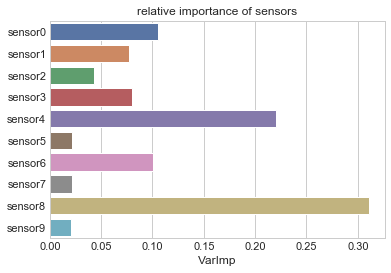

In [164]:
### feature imporatnce from RF ( white box model)
model_rf.fit(X_train,y_train)
predicted_y_test= model_rf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy of RF:",metrics.accuracy_score(y_test, model_rf.predict(X_test)))
Var_imp_df= pd.DataFrame({'VarImp': model_rf.feature_importances_}, index=X.columns)
sns.barplot(x= 'VarImp', y= Var_imp_df.index, data= Var_imp_df).set_title('relative importance of sensors')
print(Var_imp_df)
Var_imp_df.to_csv('random_forest.csv')

In [178]:
#varaible importance based on based on xgboost features , here we see variable importance based on multiple criterias 
#like on split mean weight and sample coverage
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)
xgc_predictions=xgc.predict(X_test)
print(' testing accuracy of xgboost= ', (metrics.accuracy_score(xgc_predictions, y_test)))
X.columns
X_train.shape

 testing accuracy of xgboost=  1.0


(320, 10)

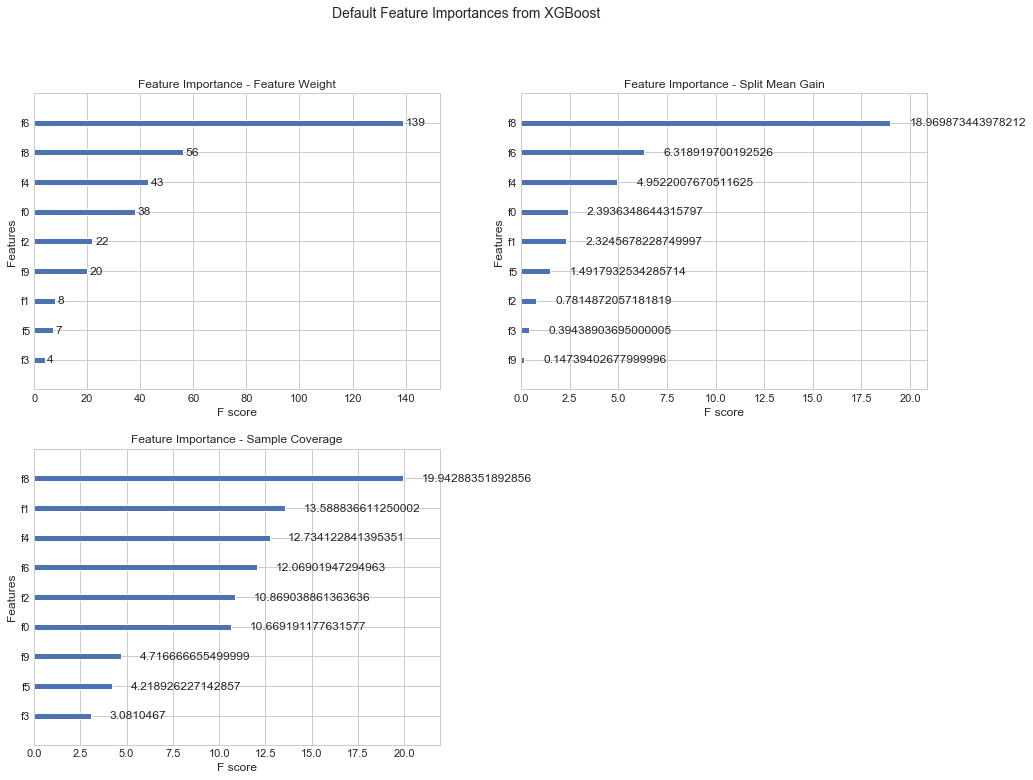

In [106]:
#plotting variable importance based on feature weight, split mean gain, sample coverage
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")


In [222]:
# xgc.get_booster().get_score(importance_type="gain").keys()
# df_xgb = pd.DataFrame({'imp': xgc.get_booster().get_score(importance_type="gain").values()}, index=xgc.get_booster().get_score(importance_type="gain").keys())
# # df_xgb['weight_imp_type']= xgc.get_booster().get_score(importance_type="weight")
# # df_xgb['cover_imp_type']= xgc.get_booster().get_score(importance_type="cover")
# # print(df_xgb)
# # type(xgc.get_booster().get_score(importance_type="gain")
# xgc.get_booster().get_score(importance_type="gain").values()
# df_xgb
df1 = pd.DataFrame(list(zip(xgc.get_booster().get_score(importance_type="gain").keys(), xgc.get_booster().get_score(importance_type="gain").values())),
               columns =['Name', 'val'])
print(df1)
df1 = pd.DataFrame(list(zip(xgc.get_booster().get_score(importance_type="gain").keys(), xgc.get_booster().get_score(importance_type="gain").values())),
               columns =['Name', 'val_gain'])
df2 = pd.DataFrame(list(zip(xgc.get_booster().get_score(importance_type="weight").keys(), xgc.get_booster().get_score(importance_type="gain").values())),
               columns =['Name', 'val_weight'])
df3 = pd.DataFrame(list(zip(xgc.get_booster().get_score(importance_type="cover").keys(), xgc.get_booster().get_score(importance_type="gain").values())),
               columns =['Name', 'val_cover'])
df=[df1,df2,df3]
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Name'],
                                            how='outer'), df)
print(df_merged)
aa= df_merged.sort_values(by=['val_gain'], ascending=False, inplace= True)
print(aa)
df_merged.to_csv('xgboost_feature_imp_updated.csv')
type(df_merged['val_gain'][1])

  Name        val
0   f8  18.969873
1   f6   6.318920
2   f0   2.393635
3   f4   4.952201
4   f1   2.324568
5   f2   0.781487
6   f5   1.491793
7   f9   0.147394
8   f3   0.394389
  Name   val_gain  val_weight  val_cover
0   f8  18.969873   18.969873  18.969873
1   f6   6.318920    6.318920   6.318920
2   f0   2.393635    2.393635   2.393635
3   f4   4.952201    4.952201   4.952201
4   f1   2.324568    2.324568   2.324568
5   f2   0.781487    0.781487   0.781487
6   f5   1.491793    1.491793   1.491793
7   f9   0.147394    0.147394   0.147394
8   f3   0.394389    0.394389   0.394389
None


numpy.float64

In [107]:
  ## ML model Explainability ##  
################## Var explainability using Surrogate model and local explainability  ###############
fb = FeatureBinarizer(negations=True, returnOrd=)True)
dfTrain, dfTrainStd = fb.fit_transform(sensor_data[sensor_data.columns[2:]])
y=sensor_data['class_label']

In [108]:
from aix360.algorithms.rbm import LogisticRuleRegression
from sklearn.metrics import accuracy_score
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)
# Train, print, and evaluate model
lrr.fit(dfTrain, y, dfTrainStd)
print('Training accuracy:', accuracy_score(y, lrr.predict(dfTrain, dfTrainStd)),'\n')
#print('Test accuracy:', accuracy_score(yTest, lrr.predict(dfTest, dfTestStd)))
print('Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
lrr.explain()

Training accuracy: 0.9975 

Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


rule/numerical feature coefficient
0                          (intercept)      5.5897
1   sensor6 <= 0.80 AND sensor6 > 0.19    -10.4034
2                      sensor2 <= 0.28    -5.47146
3                      sensor6 <= 0.68     -5.3396
4                      sensor1 <= 0.24     4.96506
5                      sensor6 <= 0.30     4.46754
6                              sensor8     4.14256
7                              sensor0     3.89661
8                      sensor2 <= 0.68     3.70213
9                      sensor1 <= 0.79     3.06575
10                     sensor8 <= 0.46    -2.49996
11                     sensor2 <= 0.77     2.43387
12                     sensor9 <= 0.73    -2.37133
13                             sensor4     2.24581
14                     sensor0 <= 0.53    -1.89152
15                     sensor3 <= 0.64    -1.10071
16                     sensor4 <= 0.50   -0.951035
17                     sensor9 <= 0.64   -0.796612
18                     sensor3 <= 0.51   -0.320819
19                             sensor3    0.106016

In [225]:
rules_table= lrr.explain()
print(type(rules_table))
rules_table.to_csv('logistic rule regression.csv')

<class 'pandas.core.frame.DataFrame'>


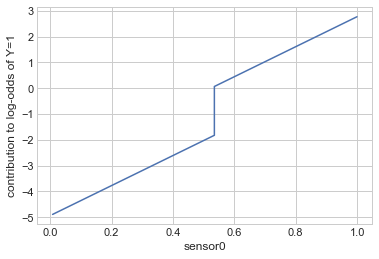

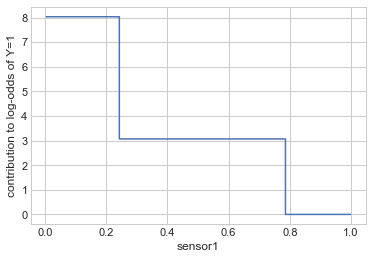

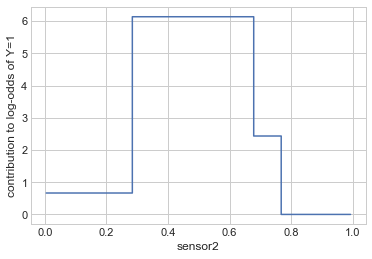

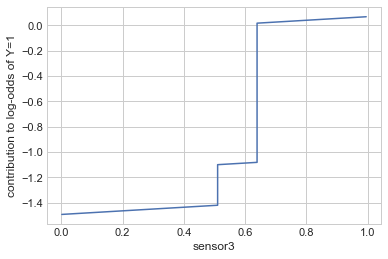

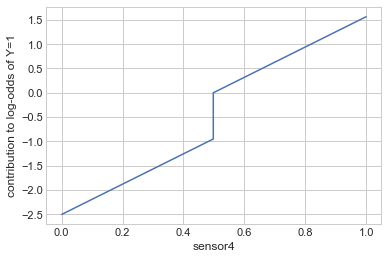

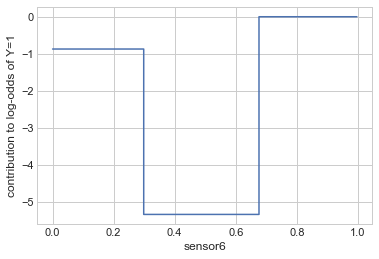

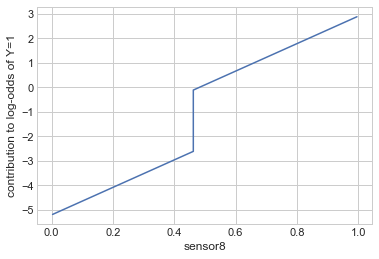

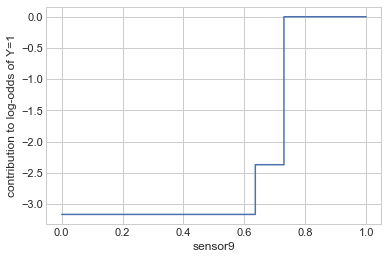

In [109]:
#here we see how change in value of sensors affects the output lebel.
list_columns= list(sensor_data.columns)
for col in list_columns:
    list_columns= list(sensor_data.columns)
    lrr.visualize(sensor_data, fb, [col])

In [110]:
### local explainability using LIME or SHAP ( LIME fits local regression model for predicted value and SHAP rebulds are model again  and 
# again on pertubed values)
## importance of feature can be different at predictions

y=sensor_data['class_label']
X= sensor_data.iloc[:, 2:]
# taking DT model


clf= DecisionTreeClassifier()
clf.fit(X, y)
explainer = shap.KernelExplainer(clf.predict_proba, X)
shap_values = explainer.shap_values(X.iloc[0,:] ,nsamples=100)

Using 400 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [111]:
# shap values  gives impotance of features based on local prediction, ptrediction of every instance.
shap_values 
shap.force_plot(explainer.expected_value[0], shap_values[0], X.iloc[0,:])

# shap value- contribution of feature to get actual value from base value

In [112]:
# this is very nice plot as we see value importance of every feature into forecast for every value of feayutes. This gives better 
# picture to see variable importance locally.
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value[0], shap_values[0], X)

In [231]:
len(shap_values)

2

In [237]:
shap_for1_class= shap_values[1]
df_shap= pd.DataFrame(shap_for1_class)

In [239]:
df_shap['op']= Y

In [242]:
df_shap.to_csv('shap_output.csv')